# Airbnb Price Prediction

In [1]:
#install library needed
!pip install category_encoders

In [2]:
#importing packages needed
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime
import warnings 
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import model_selection
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from category_encoders import QuantileEncoder
from scipy.stats import randint

In [3]:
#loading dataset
data = pd.read_csv('listings2023.csv', low_memory = False)

### EDA

In [4]:
#examining first 5 columns
data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,150,30,49,2022-06-21,0.30,3,314,1,NaN
1,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2019-12-02,0.30,2,365,0,NaN
2,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80380,-73.96751,Private room,75,2,118,2017-07-21,0.72,1,0,0,NaN
3,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Midtown,40.76457,-73.98317,Private room,68,2,575,2023-02-19,3.41,1,106,52,NaN
4,5136,"Large Sunny Brooklyn Duplex, Patio + Garden",7378,Rebecca,Brooklyn,Sunset Park,40.66265,-73.99454,Entire home/apt,275,60,3,2022-08-10,0.03,1,181,1,NaN


In [5]:
#checking shape of the data
data.shape

(42931, 18)

In [6]:
#getting info about dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42931 entries, 0 to 42930
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              42931 non-null  int64  
 1   name                            42919 non-null  object 
 2   host_id                         42931 non-null  int64  
 3   host_name                       42926 non-null  object 
 4   neighbourhood_group             42931 non-null  object 
 5   neighbourhood                   42931 non-null  object 
 6   latitude                        42931 non-null  float64
 7   longitude                       42931 non-null  float64
 8   room_type                       42931 non-null  object 
 9   price                           42931 non-null  int64  
 10  minimum_nights                  42931 non-null  int64  
 11  number_of_reviews               42931 non-null  int64  
 12  last_review                     

In [7]:
#descriptive statistics for columns in data
data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm
count,4.293100e+04,4.293100e+04,42931.000000,42931.000000,42931.000000,42931.000000,42931.000000,32627.000000,42931.000000,42931.000000,42931.000000
mean,2.222772e+17,1.516012e+08,40.728273,-73.943665,200.307167,18.111178,25.856001,1.168988,24.054809,140.262211,7.736507
std,3.344213e+17,1.621301e+08,0.057640,0.056627,895.082911,27.462513,56.616344,1.789675,80.867958,142.001486,18.290256
min,2.595000e+03,1.678000e+03,40.500314,-74.251907,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,1.940474e+07,1.608533e+07,40.687485,-73.981750,75.000000,2.000000,1.000000,0.140000,1.000000,0.000000,0.000000
50%,4.337482e+07,7.433812e+07,40.724040,-73.952620,125.000000,7.000000,5.000000,0.520000,1.000000,89.000000,0.000000
75%,6.305016e+17,2.680692e+08,40.762293,-73.924035,200.000000,30.000000,24.000000,1.670000,4.000000,289.000000,7.000000
max,8.404660e+17,5.038729e+08,40.911380,-73.710870,99000.000000,1250.000000,1842.000000,86.610000,526.000000,365.000000,1093.000000


In [8]:
#checking for null values
data.isnull().sum()

id                                    0
name                                 12
host_id                               0
host_name                             5
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10304
reviews_per_month                 10304
calculated_host_listings_count        0
availability_365                      0
number_of_reviews_ltm                 0
license                           42930
dtype: int64

In [9]:
#about 20% of reviews is null
#last review is a date - we can impute using the modal value 
#we can change reviews per month to 0 if there are no reviews for that listing
#we can drop license column

In [10]:
#modal imputation for last review columns
data['last_review'].fillna(value = data['last_review'].mode()[0], inplace = True)

In [11]:
#filling null values in reviews per month with 0 if there are no reviews for listing
data['reviews_per_month'].fillna(value = 0, inplace = True)

In [12]:
#drop the entire license column because all its values are null
data = data.drop(['license'], axis = 1)

In [13]:
#checking for null values again
data.isnull().sum()

id                                 0
name                              12
host_id                            0
host_name                          5
neighbourhood_group                0
neighbourhood                      0
latitude                           0
longitude                          0
room_type                          0
price                              0
minimum_nights                     0
number_of_reviews                  0
last_review                        0
reviews_per_month                  0
calculated_host_listings_count     0
availability_365                   0
number_of_reviews_ltm              0
dtype: int64

In [99]:
#we will drop name and hostname for our ML models, so those null values will not matter

### Exploration & Visualization

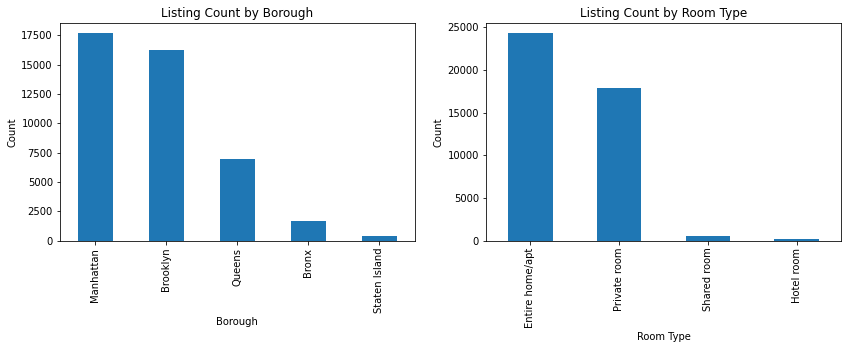

In [14]:
#viewing listing count by categorial featues
#setting figure size
plt.figure(figsize = (14,4))

#listing count by borough
plt.subplot(1,2,1)
data['neighbourhood_group'].value_counts().plot(kind='bar')
plt.xlabel('Borough')
plt.ylabel('Count')
plt.title('Listing Count by Borough')

#listing count by room type
plt.subplot(1,2,2)
data['room_type'].value_counts().plot(kind='bar')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.title('Listing Count by Room Type')

plt.show()

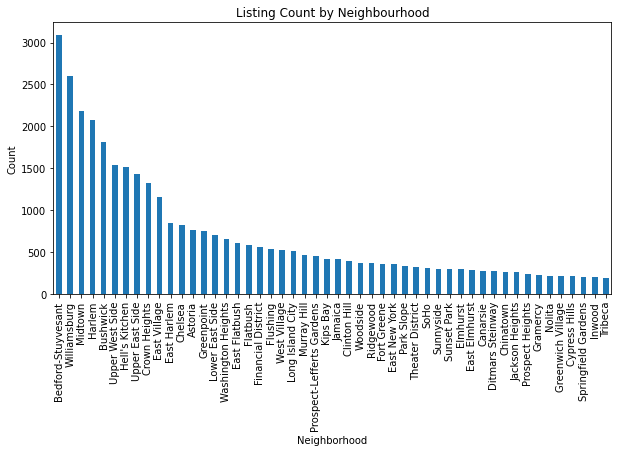

In [15]:
#viewing listing count by neighbourhood
plt.figure(figsize = (10,5))
data['neighbourhood'].value_counts(ascending = False)[0:50].plot(kind='bar')
plt.xlabel('Neighborhood')
plt.ylabel('Count')
plt.title('Listing Count by Neighbourhood')
plt.show()

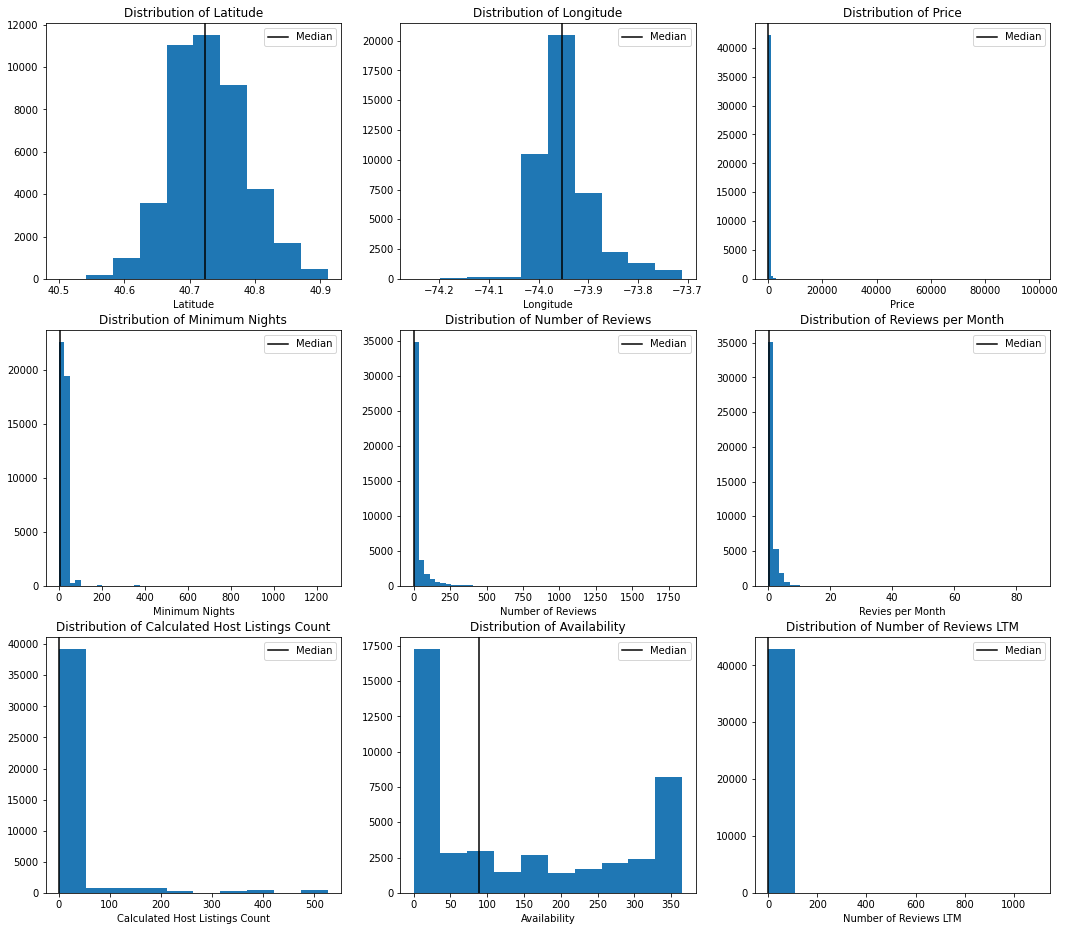

In [16]:
#viewing distributions of numeric feature variables
#setting figure size
plt.figure(figsize = (18,16))

#histogram of latitude
plt.subplot(3,3,1)
plt.hist(data['latitude'])
plt.xlabel('Latitude')
plt.axvline(x = np.median(data['latitude']), color = 'black', label = 'Median')
plt.title('Distribution of Latitude')
plt.legend()

#histogram of longitude
plt.subplot(3,3,2)
plt.hist(data['longitude'])
plt.xlabel('Longitude')
plt.axvline(x = np.median(data['longitude']), color = 'black', label = 'Median')
plt.title('Distribution of Longitude')
plt.legend()

#histogram of price
plt.subplot(3,3,3)
plt.hist(data['price'], bins = 100)
plt.xlabel('Price')
plt.axvline(x = np.median(data['price']), color = 'black', label = 'Median')
plt.title('Distribution of Price')
plt.legend() 

#histogram of minimum nights
plt.subplot(3,3,4)
plt.hist(data['minimum_nights'], bins = 50)
plt.xlabel('Minimum Nights')
plt.axvline(x = np.median(data['minimum_nights']), color = 'black', label = 'Median')
plt.title('Distribution of Minimum Nights')
plt.legend()

#histogram of number of reviews
plt.subplot(3,3,5)
plt.hist(data['number_of_reviews'], bins = 50)
plt.xlabel('Number of Reviews')
plt.axvline(x = np.median(data['number_of_reviews']), color = 'black', label = 'Median')
plt.title('Distribution of Number of Reviews')
plt.legend()

#histogram of reviews per month
plt.subplot(3,3,6)
plt.hist(data['reviews_per_month'], bins=50)
plt.xlabel('Revies per Month')
plt.axvline(x = np.median(data['reviews_per_month']), color = 'black', label = 'Median')
plt.title('Distribution of Reviews per Month')
plt.legend() 

#histogram of calculated host listing count
plt.subplot(3,3,7)
plt.hist(data['calculated_host_listings_count'])
plt.xlabel('Calculated Host Listings Count')
plt.axvline(x = np.median(data['calculated_host_listings_count']), color = 'black', label = 'Median')
plt.title('Distribution of Calculated Host Listings Count')
plt.legend() 

#histogram of availability
plt.subplot(3,3,8)
plt.hist(data['availability_365'])
plt.xlabel('Availability')
plt.axvline(x = np.median(data['availability_365']), color = 'black', label = 'Median')
plt.title('Distribution of Availability')
plt.legend()

#histogram of number of reviews ltm
plt.subplot(3,3,9)
plt.hist(data['number_of_reviews_ltm'])
plt.xlabel('Number of Reviews LTM')
plt.axvline(x = np.median(data['number_of_reviews_ltm']), color = 'black', label = 'Median')
plt.title('Distribution of Number of Reviews LTM')
plt.legend()

plt.show()

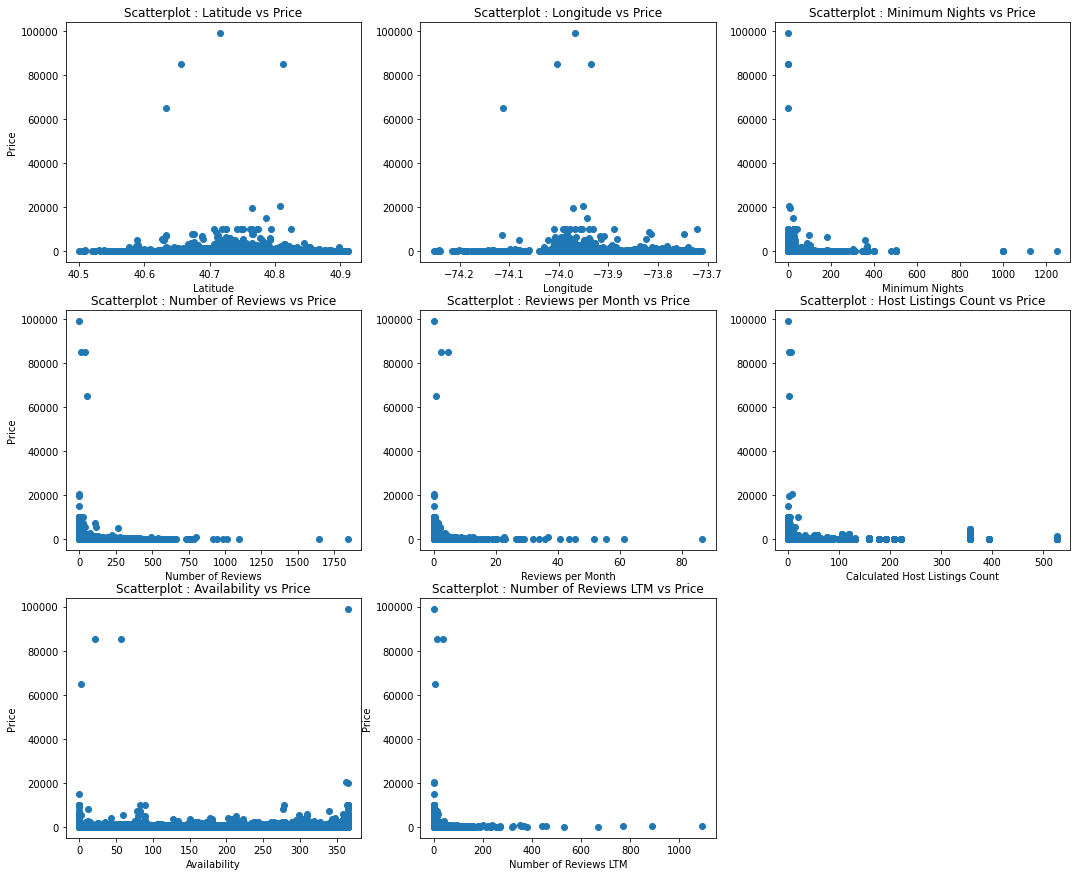

In [17]:
#viewing scatterplot of numeric feature variables
#setting figure size
plt.figure(figsize = (18,15)) 

#scatterplot of latitude vs price
plt.subplot(3,3,1)
plt.scatter(data['latitude'], data['price'])
plt.xlabel('Latitude')
plt.ylabel('Price') 
plt.title('Scatterplot : Latitude vs Price')

#scatterplot of longitude vs price
plt.subplot(3,3,2) 
plt.scatter(data['longitude'], data['price'])
plt.xlabel('Longitude')
#plt.ylabel('Price')
plt.title('Scatterplot : Longitude vs Price')

#scatterplot of minimum nights vs price
plt.subplot(3,3,3) 
plt.scatter(data['minimum_nights'], data['price'])
plt.xlabel('Minimum Nights')
#plt.ylabel('Price')
plt.title('Scatterplot : Minimum Nights vs Price')

#scatterplot of number of reviews vs price
plt.subplot(3,3,4)
plt.scatter(data['number_of_reviews'], data['price'])
plt.xlabel('Number of Reviews')
plt.ylabel('Price')
plt.title('Scatterplot : Number of Reviews vs Price')

#scatterplot of reviews per month vs price
plt.subplot(3,3,5)
plt.scatter(data['reviews_per_month'], data['price'])
plt.xlabel('Reviews per Month')
#plt.ylabel('Price')
plt.title('Scatterplot : Reviews per Month vs Price')

#scatterplot of host listing count vs price
plt.subplot(3,3,6)
plt.scatter(data['calculated_host_listings_count'], data['price'])
plt.xlabel('Calculated Host Listings Count')
#plt.ylabel('Price')
plt.title('Scatterplot : Host Listings Count vs Price')

#scatterplot of availability vs price
plt.subplot(3,3,7)
plt.scatter(data['availability_365'], data['price'])
plt.xlabel('Availability')
plt.ylabel('Price')
plt.title('Scatterplot : Availability vs Price')

#scatterplot of number of reviews ltm vs price
plt.subplot(3,3,8)
plt.scatter(data['number_of_reviews_ltm'], data['price'])
plt.xlabel('Number of Reviews LTM')
plt.ylabel('Price')
plt.title('Scatterplot : Number of Reviews LTM vs Price')

plt.show()

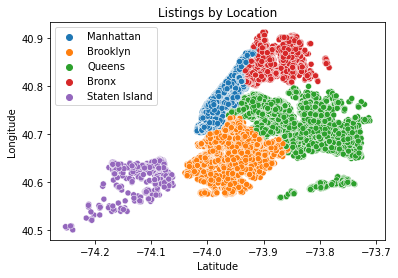

In [18]:
#viewing latitude and longitude of listings, grouped by borough 
sns.scatterplot(data = data, x='longitude', y='latitude',hue='neighbourhood_group')
plt.title('Listings by Location')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.show()

In [23]:
#resembles the map of new york city! 

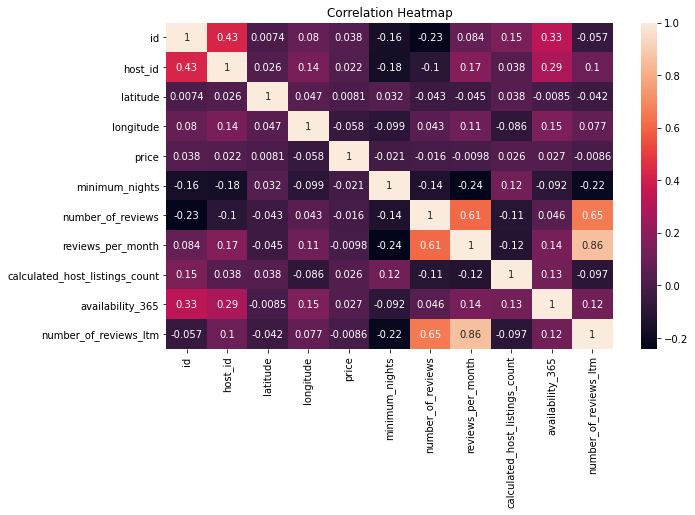

In [19]:
#plotting correlation heatmap 
plt.figure(figsize = (10,6))
sns.heatmap(data.corr(), annot = True)
plt.title('Correlation Heatmap')
plt.show()

### Data PreProcessing & Scaling

In [20]:
#converting last review, a date column, to days since last review, a numeric column
data['last_review'] = pd.to_datetime(data['last_review'])
most_recent_date = data['last_review'].max()
data['days_since_last_review'] = (most_recent_date - data['last_review']).dt.days

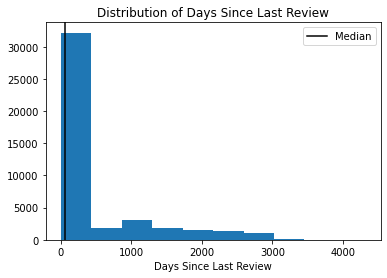

In [21]:
#viewing distribution of days since last review
plt.hist(data['days_since_last_review'])
plt.xlabel('Days Since Last Review')
plt.axvline(x = np.median(data['days_since_last_review']), color = 'black', label = 'Median')
plt.title('Distribution of Days Since Last Review')
plt.legend()

plt.show()

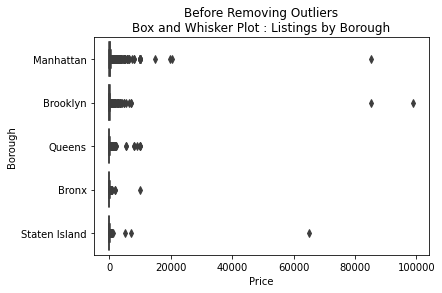

In [22]:
#viewing box and whisker plot of price for outlier detection
sns.boxplot(x = 'price', y = 'neighbourhood_group',data = data)
plt.title('Before Removing Outliers\nBox and Whisker Plot : Listings by Borough')
plt.xlabel('Price')
plt.ylabel('Borough')

plt.show()

In [23]:
#defining a function to remove outliers using IQR method
def remove_outlier_IQR(df): 
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1 
    df_final = df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))] 
    return df_final

In [24]:
#removing outliers from data using IQR method
df_outlier_removed=remove_outlier_IQR(data.price)
df_outlier_removed=pd.DataFrame(df_outlier_removed)
ind_diff=data.index.difference(df_outlier_removed.index)

for i in range(0, len(ind_diff),1):
    df_final = data.drop([ind_diff[i]])
    data = df_final

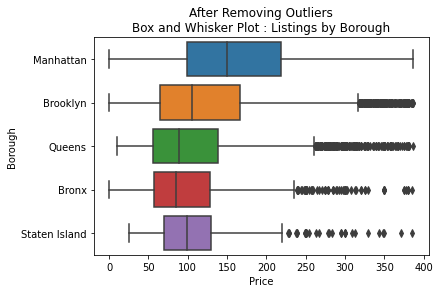

In [25]:
#viewing the box and whisker plot again
sns.boxplot(x = 'price', y = 'neighbourhood_group',data = data)
plt.title('After Removing Outliers\nBox and Whisker Plot : Listings by Borough')
plt.xlabel('Price')
plt.ylabel('Borough')
plt.show()

In [26]:
#removing non numeric columns we do not need for price prediction
#FEATURE SELECTION
#removing reviews per month, as it is highly correlated with number of reviews
df = data.drop(['id', 'name','host_id','host_name','reviews_per_month', 'last_review', 'number_of_reviews_ltm'], axis = 1)

In [27]:
#viewing first 5 rows of new dataset
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,days_since_last_review
0,Manhattan,Midtown,40.75356,-73.98559,Entire home/apt,150,30,49,3,314,258
1,Brooklyn,Bedford-Stuyvesant,40.68535,-73.95512,Private room,60,30,50,2,365,1190
2,Manhattan,Upper West Side,40.80380,-73.96751,Private room,75,2,118,1,0,2054
3,Manhattan,Midtown,40.76457,-73.98317,Private room,68,2,575,1,106,15
4,Brooklyn,Sunset Park,40.66265,-73.99454,Entire home/apt,275,60,3,1,181,208


In [28]:
#One Hot Encoding 
#getting dummies of borough and room types
df_rev = pd.get_dummies(df, columns = ['neighbourhood_group', 'room_type'])
df_rev.head()

,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,days_since_last_review,neighbourhood_group_Bronx,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
0,Midtown,40.75356,-73.98559,150,30,49,3,314,258,0,0,1,0,0,1,0,0,0
1,Bedford-Stuyvesant,40.68535,-73.95512,60,30,50,2,365,1190,0,1,0,0,0,0,0,1,0
2,Upper West Side,40.80380,-73.96751,75,2,118,1,0,2054,0,0,1,0,0,0,0,1,0
3,Midtown,40.76457,-73.98317,68,2,575,1,106,15,0,0,1,0,0,0,0,1,0
4,Sunset Park,40.66265,-73.99454,275,60,3,1,181,208,0,1,0,0,0,1,0,0,0


In [29]:
#renaming columns for ease of use
df_rev.rename(columns={'neighbourhood_group_Bronx': 'bronx', 'neighbourhood_group_Brooklyn': 'brooklyn', 
                      'neighbourhood_group_Manhattan':'manhattan', 'neighbourhood_group_Queens':'queens', 
                      'neighbourhood_group_Staten Island':'staten_island', 'room_type_Entire home/apt':'entire_apt', 
                      'room_type_Private room': 'private', 'room_type_Shared room':'shared', 'room_type_Hotel room': 'hotel'}, inplace=True)

In [30]:
#dropping 1 column each to remove dependence between other categories
df_rev = df_rev.drop(['staten_island', 'entire_apt'], axis = 1)
df_rev.head()

,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,days_since_last_review,bronx,brooklyn,manhattan,queens,hotel,private,shared
0,Midtown,40.75356,-73.98559,150,30,49,3,314,258,0,0,1,0,0,0,0
1,Bedford-Stuyvesant,40.68535,-73.95512,60,30,50,2,365,1190,0,1,0,0,0,1,0
2,Upper West Side,40.80380,-73.96751,75,2,118,1,0,2054,0,0,1,0,0,1,0
3,Midtown,40.76457,-73.98317,68,2,575,1,106,15,0,0,1,0,0,1,0
4,Sunset Park,40.66265,-73.99454,275,60,3,1,181,208,0,1,0,0,0,0,0


In [31]:
#seperating features and target
Y = df_rev['price']
X = df_rev.drop(['price'], axis = 1)

In [32]:
print('There are',len(X['neighbourhood'].unique()), 'unique neighbourhoods in this dataset.')

There are 222 unique neighbourhoods in this dataset.


In [33]:
#encoding a categorical column into a numeric one using quantile encoding
enc = QuantileEncoder(cols = ['neighbourhood'], quantile = 0.5, m =1.0).fit(X, Y)

In [34]:
#transforming the data using the quantile encoder
X_data = enc.transform(X)

In [35]:
#resetting indices
Y.reset_index(inplace=True, drop=True)
X_data.reset_index(inplace=True, drop=True)
X_data.head()

,neighbourhood,latitude,longitude,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,days_since_last_review,bronx,brooklyn,manhattan,queens,hotel,private,shared
0,198.949025,40.75356,-73.98559,30,49,3,314,258,0,0,1,0,0,0,0
1,95.007734,40.68535,-73.95512,30,50,2,365,1190,0,1,0,0,0,1,0
2,149.976895,40.80380,-73.96751,2,118,1,0,2054,0,0,1,0,0,1,0
3,198.949025,40.76457,-73.98317,2,575,1,106,15,0,0,1,0,0,1,0
4,90.094915,40.66265,-73.99454,60,3,1,181,208,0,1,0,0,0,0,0


In [36]:
#seperating numeric and indicator columns
numeric_cols = ['neighbourhood','minimum_nights', 'number_of_reviews','calculated_host_listings_count',
                'availability_365','days_since_last_review','latitude','longitude']
non_numeric_cols = ['bronx','brooklyn','manhattan','queens','private','shared', 'hotel']

In [37]:
#scaling numeric feature variables
X_non_numeric = X_data[non_numeric_cols]
X_scaled1 = pd.DataFrame(StandardScaler().fit_transform(X_data.drop(non_numeric_cols, axis = 1)), columns = numeric_cols)
#combining scaled features with indicator variables
X_data_scaled = pd.concat([X_scaled1, X_non_numeric], axis = 1)
X_data_scaled.head()

,neighbourhood,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,days_since_last_review,latitude,longitude,bronx,brooklyn,manhattan,queens,private,shared,hotel
0,1.962427,0.440613,-0.774897,0.417307,0.383785,-0.247570,1.252984,-0.272408,0,0,1,0,0,0,0
1,-0.624134,-0.720748,-0.241263,0.417307,0.401097,-0.260884,1.613791,0.981269,0,1,0,0,1,0,0
2,0.743764,1.296013,-0.458254,-0.600427,1.578334,-0.274198,-0.968459,2.143476,0,0,1,0,1,0,0
3,1.962427,0.628073,-0.732515,-0.600427,9.490055,-0.274198,-0.218545,-0.599279,0,0,1,0,1,0,0
4,-0.746388,-1.107244,-0.931642,1.507737,-0.412581,-0.274198,0.312054,-0.339666,0,1,0,0,0,0,0


In [38]:
#splitting data for cross validation
X_train, X_test, y_train, y_test = train_test_split(X_data_scaled, Y, test_size = 0.2, random_state = 42)

### ML Analysis
#### Multiple Linear Regression

In [39]:
#fitting a multiple linear model
mlm = LinearRegression()
mlm.fit(X_train, y_train)
y_pred_mlm = mlm.predict(X_test)
print("Multiple Linear Regression : R-squared = {:0.4f}".format(mlm.score(X_test,y_test)))

Multiple Linear Regression : R-squared = 0.4377


In [40]:
#viewing the coefficients
pd.Series(mlm.coef_, index = X_train.columns)

neighbourhood                     26.159905
minimum_nights                     4.917237
number_of_reviews                 -5.760605
calculated_host_listings_count   -10.181256
availability_365                  -2.129821
days_since_last_review             4.090528
latitude                           5.608809
longitude                         -5.183751
bronx                             11.426695
brooklyn                          28.777408
manhattan                         23.488634
queens                            30.680708
private                          -75.440816
shared                           -91.367723
hotel                            -18.810433
dtype: float64

In [41]:
#evaluation metrics - MSE, RMSE, MAE
mlm_mse = mean_squared_error(y_test, y_pred_mlm)
print("Multiple Linear Regression : MSE = {:0.2f}".format(mlm_mse))

mlm_rmse = np.sqrt(mlm_mse)
print("Multiple Linear Regression : RMSE = {:0.2f}".format(mlm_rmse))

mlm_mae = mean_absolute_error(y_test, y_pred_mlm)
print("Multiple Linear Regression : MAE = {:0.2f}".format(mlm_mae))

Multiple Linear Regression : MSE = 3671.19
Multiple Linear Regression : RMSE = 60.59
Multiple Linear Regression : MAE = 45.11


#### Ridge Regression

In [42]:
#setting a range for lambdas
lambdas = np.linspace(0,40,201)

In [43]:
#hyper parameter tuning - finding the optimal lambda
cont = np.empty([len(lambdas),2])*np.NaN # [lambda error]
for ii in range(len(lambdas)):
    ridgeModel = Ridge(alpha=lambdas[ii]).fit(X_train, y_train)
    cont[ii,0] = lambdas[ii]
    error = mean_squared_error(y_test,ridgeModel.predict(X_test),squared=False)
    cont[ii,1] = error
    
ridge_lamda = lambdas[np.argmax(cont[:,1]==np.min(cont[:,1]))]

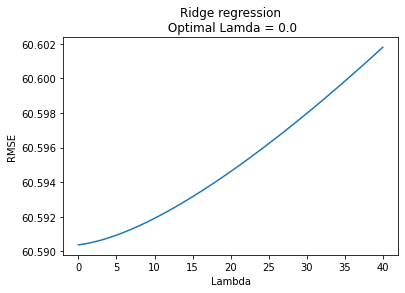

In [44]:
#plotting RMSE for each lamda
plt.plot(cont[:,0],cont[:,1])
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.title('Ridge regression\n Optimal Lamda = '+str(round(ridge_lamda, 2)))
plt.show()

#### LASSO 

In [85]:
#hyper parameter tuning - finding the optimal lambda
cont2 = np.empty([len(lambdas),2])*np.NaN # [lambda error]
for ii in range(len(lambdas)):
    lassoModel = Lasso(alpha=lambdas[ii]).fit(X_train, y_train)
    cont2[ii,0] = lambdas[ii]
    error = mean_squared_error(y_test,lassoModel.predict(X_test),squared=False)
    cont2[ii,1] = error
    
lasso_lamda = lambdas[np.argmax(cont2[:,1]==np.min(cont2[:,1]))]

<ipython-input-85-90fbff52e59d>:4: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  lassoModel = Lasso(alpha=lambdas[ii]).fit(X_train, y_train)
/Users/varshikaprasanna/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/varshikaprasanna/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.759e+07, tolerance: 2.057e+04 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  

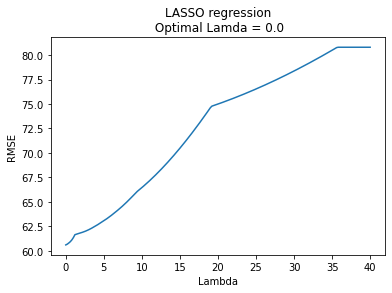

In [86]:
#plotting RMSE for each lamda
plt.plot(cont2[:,0],cont2[:,1])
plt.xlabel('Lambda')
plt.ylabel('RMSE')
plt.title('LASSO regression\n Optimal Lamda = '+str(round(lasso_lamda, 2)))
plt.show()

#### XGBoost Regressor

In [58]:
#defining potential ranges for hyperparameters
model = GradientBoostingRegressor()
parameters = {'learning_rate': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                  'n_estimators' : randint(100, 1000),
                  'max_depth'    : [2,4,6,8,10,12,14,16,18,20],
              'min_samples_split' : [2,3,4,5,6,7,8,9,10]
                 }

In [59]:
#hyperparameter tuning
random_src = RandomizedSearchCV(estimator=model, param_distributions = parameters,
                               cv = 2, n_iter = 10, n_jobs=-1)
random_src.fit(X_train, y_train)

RandomizedSearchCV(cv=2, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0, 0.1, 0.2, 0.3, 0.4,
                                                          0.5, 0.6, 0.7, 0.8,
                                                          0.9, 1],
                                        'max_depth': [2, 4, 6, 8, 10, 12, 14,
                                                      16, 18, 20],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fa568d571c0>})

In [60]:
#getting optimal hyperparameters
random_src.best_params_

{'learning_rate': 0.2,
 'max_depth': 4,
 'min_samples_split': 3,
 'n_estimators': 680}

In [45]:
#training an XGBoost Regressor using optimal hyperparameters
reg = GradientBoostingRegressor(n_estimators = 680,
    max_depth = 4,
    min_samples_split = 3,
    learning_rate = 0.2)

In [46]:
#fitting the model to the training data
reg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, max_depth=4, min_samples_split=3,
                          n_estimators=680)

In [47]:
#getting predcitions for the test data
y_pred_reg = reg.predict(X_test)

In [48]:
#r^2 coefficient
print("XGBoost Regressor : R-squared = {:0.4f}".format(reg.score(X_test, y_test)))

XGBoost Regressor : R-squared = 0.5627


In [49]:
#evaluation metrics - MSE, RMSE, MAE
reg_mse = mean_squared_error(y_test, y_pred_reg)
print("XGBoost Regressor : MSE = {:0.2f}".format(reg_mse))

reg_rmse = np.sqrt(reg_mse)
print("XGBoost Regressor : RMSE = {:0.2f}".format(reg_rmse))

reg_mae = mean_absolute_error(y_test, y_pred_reg)
print("XGBoost Regressor : MAE = {:0.2f}".format(reg_mae))

XGBoost Regressor : MSE = 2854.72
XGBoost Regressor : RMSE = 53.43
XGBoost Regressor : MAE = 38.62


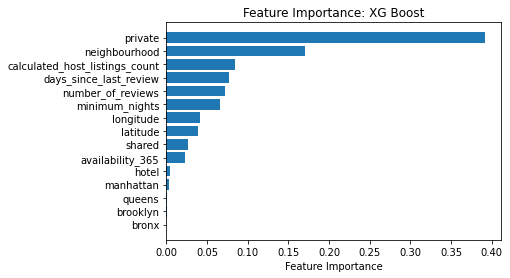

In [61]:
#finding what feature are important for classification
plt.figure(figsize=(6, 4))
sort = reg.feature_importances_.argsort()
plt.barh(X_train.columns[sort], reg.feature_importances_[sort])
plt.xlabel("Feature Importance")
plt.title('Feature Importance: XG Boost')
plt.show()

#### SVR

In [68]:
#setting potential ranges for hyperparameters
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'linear']} 

In [71]:
#SVR hyperparameter tuning
random_search_svr = RandomizedSearchCV(estimator=SVR(), param_distributions = param_grid,
                               cv = 5, n_iter = 10, n_jobs=-1)
random_search_svr.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf', 'linear']})

In [72]:
#extracting best hyperparameters
random_search_svr.best_params_

{'kernel': 'rbf', 'gamma': 0.1, 'C': 10}

In [51]:
#fitting an SVR model based on optimal hyperparameters
svr = SVR(kernel = 'rbf', gamma = 0.1, C = 100)
svr.fit(X_train, y_train)

SVR(C=100, gamma=0.1)

In [52]:
#getting model predictions for test data
y_pred_svr = svr.predict(X_test)

In [53]:
#r^2 coefficient
print("Support Vector Regressor : R-squared = {:0.4f}".format(svr.score(X_test, y_test)))

Support Vector Regressor : R-squared = 0.5175


In [54]:
#evaluation metrics - MSE, RMSE, MAE
svr_mse = mean_squared_error(y_test, y_pred_svr)
print("Support Vector Regressor : MSE = {:0.2f}".format(svr_mse))

svr_rmse = np.sqrt(svr_mse)
print("Support Vector Regressor : RMSE = {:0.2f}".format(svr_rmse))

svr_mae = mean_absolute_error(y_test, y_pred_svr)
print("Support Vector Regressor : MAE = {:0.2f}".format(svr_mae))

Support Vector Regressor : MSE = 3149.94
Support Vector Regressor : RMSE = 56.12
Support Vector Regressor : MAE = 38.65


In [56]:
#table with different evaluation metrics for different models
pd.DataFrame({'MSE': [round(mlm_mse, 2), round(reg_mse, 2), round(svr_mse, 2)], 
            'RMSE':[round(mlm_rmse, 2), round(reg_rmse, 2), round(svr_rmse, 2)], 
             'MAE':[ round(mlm_mae, 2), round(reg_mae, 2), round(svr_mae, 2)]}, index = ['Linear', 'XGBoost','SVR'])

,MSE,RMSE,MAE
Linear,3671.19,60.59,45.11
XGBoost,2854.72,53.43,38.62
SVR,3149.94,56.12,38.65
